In [1]:
import lightning.pytorch as pl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import yfinance as yf
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
sp500 = yf.download("^GSPC", period="max", start="2010-1-1")
# sp500 = yf.download("000001.SZ", period="max", start="2023-1-1")
sp500.drop(columns=["Adj Close"], inplace=True)
sp500.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000


In [3]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3600 entries, 2010-01-04 to 2024-04-23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3600 non-null   float64
 1   High    3600 non-null   float64
 2   Low     3600 non-null   float64
 3   Close   3600 non-null   float64
 4   Volume  3600 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 168.8 KB


In [4]:
df = sp500["Close"].to_frame()

In [5]:
df

,Close
Date,
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980
...,...
2024-04-17,5022.209961
2024-04-18,5011.120117
2024-04-19,4967.229980


In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x: np.ndarray, sequence_length: int):
        self.x = x
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.x) - (self.sequence_length)

    def __getitem__(self, idx):
        X = torch.tensor(self.x[idx : idx + self.sequence_length]).to(
            dtype=torch.float32
        )
        y = torch.tensor(self.x[idx + self.sequence_length]).to(dtype=torch.float32)
        return X, y

In [7]:
from sklearn.model_selection import train_test_split
import os


class StockDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data: pd.DataFrame,
        sequence_length: int,
        test_size: float = 0.2,
        batch_size: int = 10,
        feature_name: str = "",
    ):
        super().__init__()
        self.data = data
        self.sequence_length = sequence_length
        self.test_size = test_size
        self.batch_size = batch_size
        self.feature_name = feature_name

        self.training: Dataset
        self.validation: Dataset
        self.test: Dataset
        self.predict: Dataset

        self.target_scaler = MinMaxScaler()

        self.setup()

    def preprocess_data(self):
        self.data["target"] = self.data[self.feature_name]
        self.data["time_index"] = np.arange(len(self.data))

    def split_data(self):
        time_indices = self.data["time_index"].values
        train_indices, test_indices = train_test_split(
            time_indices, test_size=self.test_size, shuffle=False
        )
        train_indices, val_indices = train_test_split(
            train_indices, test_size=0.1, shuffle=False
        )
        return train_indices, val_indices, test_indices

    def scale_target(self, df, indices):
        scaled_values = self.target_scaler.transform(df.loc[indices, ["target"]])
        df.loc[indices, "target"] = scaled_values

    def setup(self, stage=None):
        self.preprocess_data()
        train_indices, val_indices, test_indices = self.split_data()
        train_df = self.data.loc[self.data["time_index"].isin(train_indices)]
        val_df = self.data.loc[self.data["time_index"].isin(val_indices)]
        test_df = self.data.loc[self.data["time_index"].isin(test_indices)]

        self.target_scaler.fit(train_df[["target"]])
        self.scale_target(train_df, train_df.index)
        self.scale_target(val_df, val_df.index)
        self.scale_target(test_df, test_df.index)

        self.training = TimeSeriesDataset(
            train_df["target"].to_numpy().reshape(-1, 1), self.sequence_length
        )

        self.validation = TimeSeriesDataset(
            val_df["target"].to_numpy().reshape(-1, 1), self.sequence_length
        )

        self.test = TimeSeriesDataset(
            test_df["target"].to_numpy().reshape(-1, 1), self.sequence_length
        )

        self.predict = TimeSeriesDataset(
            pd.concat([train_df["target"], val_df["target"], test_df["target"]])
            .to_numpy()
            .reshape(-1, 1),
            self.sequence_length,
        )

    def train_dataloader(self):
        return DataLoader(
            self.training,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validation,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict,
            batch_size=self.batch_size,
            shuffle=False,
        )

In [8]:
# Creating the LSTM model
from torch import nn


class LSTMModel(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 1,
        hidden_dim: int = 128,
        num_layers: int = 2,
        output_dim: int = 1,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        # print(x.shape)
        output = self(x)
        loss = F.mse_loss(output, y)
        self.log(f"train_loss", loss, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x_hat = self(x)
        test_loss = F.mse_loss(x_hat, y)
        self.log("test_loss", test_loss, logger=True)

    def validation_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x_hat = self(x)
        test_loss = F.mse_loss(x_hat, y)
        self.log("validation_loss", test_loss, logger=True)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        optimiser = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimiser

In [9]:
## BEST TRAINING PARAMS
N_EPOCHS = 500
BATCH_SIZE = 8
SEQUENCE_LENGTH = 5
N_HIDDEN = 64
N_LAYERS = 1
LR = 1e-4

In [10]:
datamodule = StockDataModule(
    data=df,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
    feature_name="Close",
)

In [11]:
# dataloader = datamodule.train_dataloader()
# for x, y in dataloader:
#     print(x.shape)
#     print(y.shape)
#     break

torch.Size([8, 5, 1])
torch.Size([8, 1])


In [12]:
model = LSTMModel(input_dim=1, hidden_dim=128, num_layers=2, output_dim=1)
print(model)

LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [13]:
from torchinfo import summary


summary(model, input_size=(1, SEQUENCE_LENGTH, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 1]                    --
├─LSTM: 1-1                              [1, 5, 128]               199,168
├─Linear: 1-2                            [1, 16]                   2,064
├─Linear: 1-3                            [1, 1]                    17
Total params: 201,249
Trainable params: 201,249
Non-trainable params: 0
Total mult-adds (M): 1.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.80
Estimated Total Size (MB): 0.81

In [14]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("lightning_logs", name="index-prediction")

early_stop_callback = EarlyStopping(
    monitor="validation_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)

model_checkpoint = ModelCheckpoint(
    dirpath="univariate-checkpoints",
    filename="{epoch}-{val_loss:.2f}-{other_metric:.2f}",
)
rich_progress_bar = RichProgressBar()
trainer = pl.Trainer(
    logger=logger,
    callbacks=[model_checkpoint, early_stop_callback],
    max_epochs=N_EPOCHS,
    accelerator="cpu",
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [15]:
trainer.fit(model=model, datamodule=datamodule)

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/raopend/Workspace/stock-index-prediction/notebook/univariate-checkpoints exists and is not empty.

  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 199 K 
1 | fc1  | Linear | 2.1 K 
2 | fc2  | Linear | 17    
--------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.805     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [16]:
trainer.test(model=model, datamodule=datamodule)

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.017496826127171516    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.017496826127171516}]

In [17]:
trainer.validate(model=model, datamodule=datamodule)

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │   0.006177565082907677    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.006177565082907677}]

In [18]:
prediction = trainer.predict(model=model, datamodule=datamodule)

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
scaler = datamodule.target_scaler

In [26]:
scaler.data_max_, scaler.data_min_

(array([3386.14990234]), array([1022.58001709]))

In [20]:
prediction = torch.cat(prediction)
prediction = prediction.detach().numpy()
prediction = scaler.inverse_transform(prediction)
prediction

array([[1129.6232],
       [1132.3445],
       [1132.2666],
       ...,
       [4568.8916],
       [4547.9375],
       [4543.9937]], dtype=float32)

In [21]:
prediction = prediction.flatten()
prediction

array([1129.6232, 1132.3445, 1132.2666, ..., 4568.8916, 4547.9375,
       4543.9937], dtype=float32)

In [22]:
# # scaler.inverse_transform(test).shape
actual_final = []
for ele in datamodule.predict_dataloader():
    actual_final.extend(ele[1].squeeze(1).tolist())
actual_final = np.fromiter(actual_final, dtype=np.float32)
actual_final = scaler.inverse_transform(actual_final.reshape(-1, 1))
# actual_final = actual_final
actual_final = actual_final.squeeze(1).tolist()
actual_final

[1146.97998046875,
 1136.219970703125,
 1145.6800537109375,
 1148.4599609375,
 1136.030029296875,
 1150.22998046875,
 1138.0400390625,
 1116.47998046875,
 1091.760009765625,
 1096.780029296875,
 1092.1700439453125,
 1097.5,
 1084.530029296875,
 1073.8699951171875,
 1089.18994140625,
 1103.3199462890625,
 1097.280029296875,
 1063.1099853515625,
 1066.18994140625,
 1056.739990234375,
 1070.52001953125,
 1068.1300048828125,
 1078.469970703125,
 1075.510009765625,
 1094.8699951171875,
 1099.510009765625,
 1106.75,
 1109.1700439453125,
 1108.010009765625,
 1094.5999755859375,
 1105.239990234375,
 1102.93994140625,
 1104.489990234375,
 1115.7099609375,
 1118.31005859375,
 1118.7900390625,
 1122.969970703125,
 1138.699951171875,
 1138.5,
 1140.449951171875,
 1145.6099853515625,
 1150.239990234375,
 1149.989990234375,
 1150.510009765625,
 1159.4599609375,
 1166.2099609375,
 1165.8299560546875,
 1159.9000244140625,
 1165.81005859375,
 1174.1700439453125,
 1167.719970703125,
 1165.72998046875,
 

In [23]:
temp = pd.DataFrame(zip(prediction, actual_final), columns=["y_pred", "test"])

In [24]:
temp

,y_pred,test
0,1129.623169,1146.979980
1,1132.344482,1136.219971
2,1132.266602,1145.680054
3,1133.159302,1148.459961
4,1134.441650,1136.030029
...,...,...
3590,4611.020508,5022.209961
3591,4590.940430,5011.120117
3592,4568.891602,4967.229980
3593,4547.937500,5010.600098


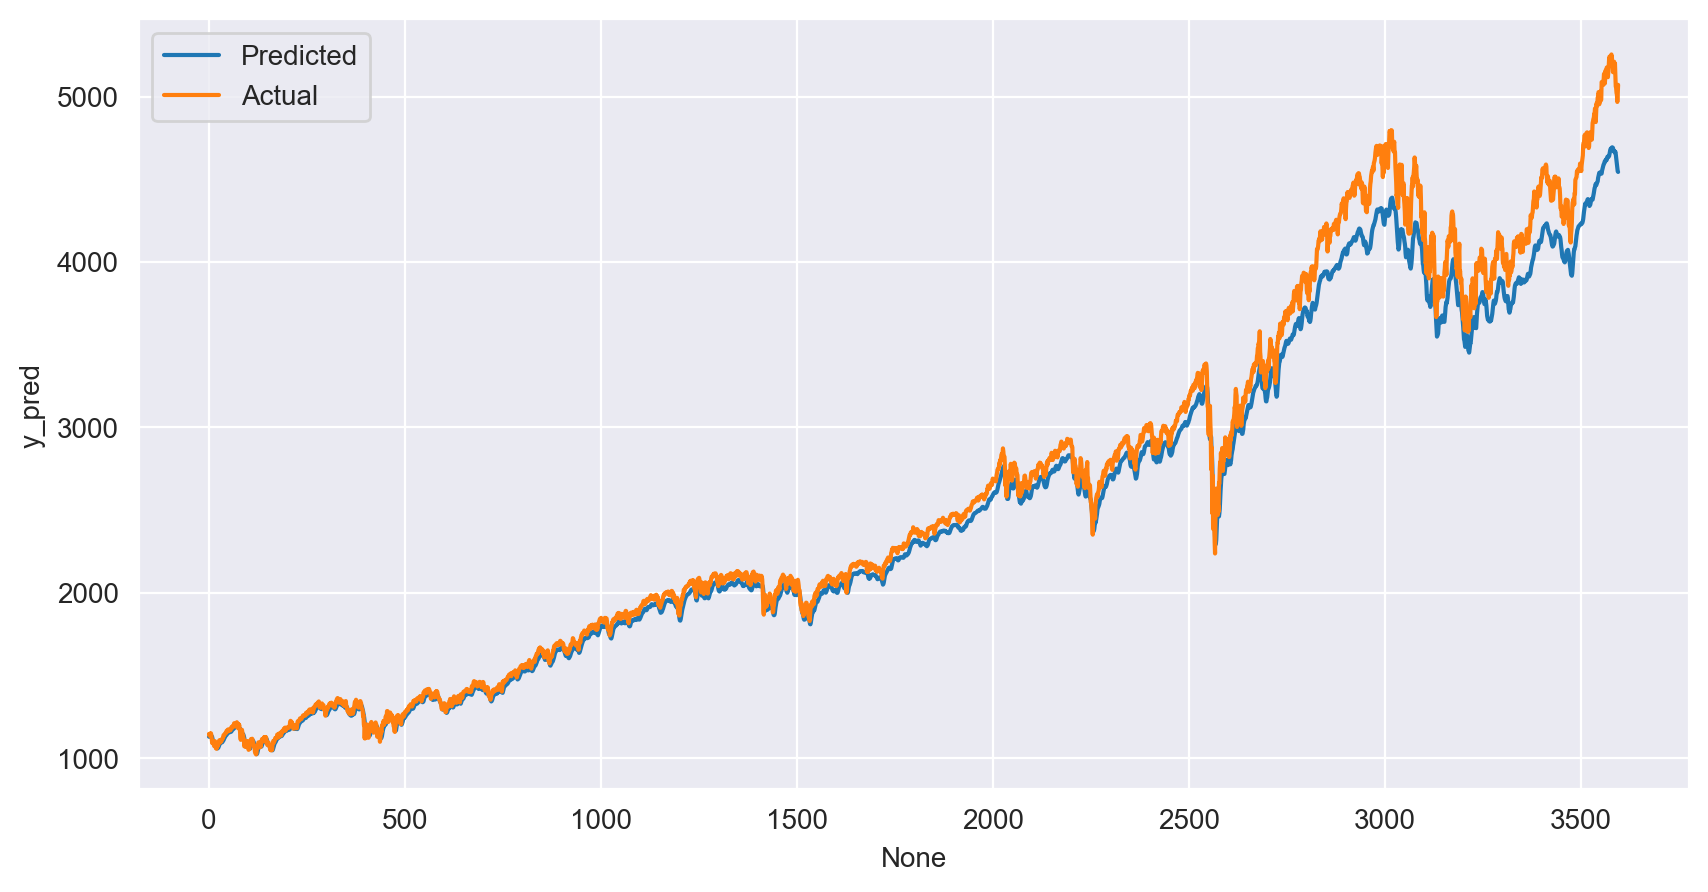

In [25]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data=temp, x=temp.index, y="y_pred", label="Predicted")
sns.lineplot(data=temp, x=temp.index, y="test", label="Actual")
plt.show()

In [330]:
model.eval()
torch.onnx.export(
    model, torch.zeros(1, 5, 1), "./model/TimeSeries_LSTM.onnx", export_params=True
)